In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, hp, tpe, space_eval

from sklearn.model_selection import KFold, TimeSeriesSplit
import lightgbm as lgb
from time import time
from tqdm import tqdm_notebook

import gc
import warnings
warnings.filterwarnings('ignore')

/Users/didi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# 导入数据

In [2]:
# NROWS = None
NROWS = 50000

train_identity = pd.read_csv('../input/train_identity.csv', nrows=NROWS)
train_transaction = pd.read_csv('../input/train_transaction.csv', nrows=NROWS)
train = train_transaction.merge(train_identity, how='left', on='TransactionID')

test_identity = pd.read_csv('../input/test_identity.csv', nrows=NROWS)
test_transaction = pd.read_csv('../input/test_transaction.csv', nrows=NROWS)
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

sub = pd.read_csv('../input/sample_submission.csv', nrows=NROWS)

gc.enable()
del train_identity, train_transaction
del test_identity, test_transaction
gc.collect()

print("train.shape:", train.shape)
print("test.shape:", test.shape)
train.head(3)

train.shape: (50000, 434)
test.shape: (50000, 433)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

## 内存优化

In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min  and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum()/ 1024**2
    print('Memory usage after optimization is: {:.2f} MB, {:.1f}% reduction'.\
          format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
%%time
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

Memory usage after optimization is: 53.07 MB, 68.0% reduction
Memory usage after optimization is: 50.93 MB, 69.2% reduction
CPU times: user 9.69 s, sys: 10.9 s, total: 20.6 s
Wall time: 21.3 s


# 特征工程

In [5]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [6]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

## 特征分类: 按特征名分类

### 时间相关特征(TransactionDT)

In [7]:
def transform_TransactionDT(df):
    START_DATE = '2017-12-01'
    start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['Date'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))

    df['Weekday'] = df['Date'].dt.dayofweek
    df['Hour'] = df['Date'].dt.hour
    df['Day'] = df['Date'].dt.day
    df['Morning'] = (df['Hour'] >= 7) & (df['Hour'] <= 11).astype('int')
    df['Noon'] = (df['Hour'] >=12) & (df['Hour'] <= 18).astype('int')
    df['Evening'] = (df['Hour'] >= 19) & (df['Hour'] <=23).astype('int')
    df['Midnight'] = (df['Hour'] >= 0) & (df['Hour'] <=6).astype('int')
    
    del df['Date']
    
    return df

In [8]:
train = transform_TransactionDT(train)
test = transform_TransactionDT(test)

### 金额(TransactionAmt)

In [9]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
train['TransAmtLog'] = np.log(train['TransactionAmt'])
train['TransAmtDemical'] = train['TransactionAmt'].astype('str').str.split('.', expand=True)[1].str.len()

test['TransactionAmt'] = test['TransactionAmt'].astype(float)
test['TransAmtLog'] = np.log(test['TransactionAmt'])
test['TransAmtDemical'] = test['TransactionAmt'].astype('str').str.split('.', expand=True)[1].str.len()

### ProductCD

In [10]:
train.ProductCD.unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

### card

In [11]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))



train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

### address
both are for purchaser, addr1 as billing region, addr2 as billing country

In [12]:
train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')

### distance

In [13]:
train["dist1_plus_dist2"]  = train["dist1"] + train["dist2"]
train["dist1_minus_dist2"] = train["dist1"] - train["dist2"]
train["dist1_times_dist2"]  = train["dist1"] * train["dist2"]
train["dist1_divides_dist2"] = train["dist1"] / train["dist2"]

test["dist1_plus_dist2"]  = test["dist1"] + test["dist2"]
test["dist1_minus_dist2"] = test["dist1"] - test["dist2"]
test["dist1_times_dist2"]  = test["dist1"] * test["dist2"]
test["dist1_divides_dist2"] = test["dist1"] / test["dist2"]

### 邮箱

In [14]:
def transform_email(df):
    for col in ['P_emaildomain', 'R_emaildomain']:
        col1 = col.replace('domain', '_suffix')
        df[col1] = df[col].str.rsplit('.', expand=True).iloc[:, -1]
        
        col2 = col.replace('domain', 'Corp')
        df[col2] = df[col]
        df.loc[df[col].isin(['gmail.com', 'gmail']), col2] = 'Google'
        df.loc[df[col].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk', 'yahoo.co.jp', 
                             'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.com.mx', 
                             'ymail.com']), col2] = 'Yahoo'
        df.loc[df[col].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es', 
                             'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr', 
                             'hotmail.fr']), col2] = 'Microsoft'
        df.loc[df[col].isin(['aol.com', 'verizon.net']), col2] = 'Verizon'
        df.loc[df[col].isin(['att.net', 'sbcglobal.net', 'bellsouth.net']), col2] = 'AT&T'
        df.loc[df[col].isin(['icloud.com', 'mac.com', 'me.com']), col2] = 'Apple'
        df.loc[df[col2].isin(df[col2].value_counts()[df[col2].value_counts() <= 1000].index), col2] = 'Others'
    
    return df

In [15]:
train = transform_email(train)
test = transform_email(test)

### C1-C14

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.


### D1-D15
timedelta, such as days between previous transaction, etc.

### M1-M9
match, such as names on card and address, etc.

In [16]:
MFeatures = ["M1","M2","M3","M4","M5","M6","M7","M8","M9"]
for feature in MFeatures:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))


### Vxxx
Vesta engineered rich features, including ranking, counting, and other entity relations.

### id相关特征

In [17]:
def transform_id_cols(df):
#     df['id_01_cut'] = pd.cut(df['id_01'], bins=[-100, -30, -20, -10, -5, 0])
    
    df['id_05_d'] = df['id_05']
    df['id_05_d'].where(df[df['id_05_d'].notnull()]['id_05_d'] == 0, 1, inplace=True)
    
#     df['id_06_cut'] = pd.cut(df['id_06'], bins=[-100, -10, -5, 0])
    df['id_06_d'] = df['id_06']
    df['id_06_d'].where(df[df['id_06_d'].notnull()]['id_06_d'] == 0, 1, inplace=True)
    
    # Dealing with id_30
    df['id_30_count'] = df['id_30'].map(df['id_30'].value_counts(dropna=False))
    df['System'] = df['id_30'].astype('str').str.split('.', expand=True)[0].str.split('_', expand=True)[0]
    df['SystemCorp'] = df['System'].str.split(expand=True)[0]
    
    # Dealing with id_31
    df['LastestBrowser'] = df['id_31']
    df.loc[df['LastestBrowser'].isin(['samsung browser 7.0', 'opera 53.0', 'mobile safari 10.0', 'chrome 63.0 for android', 
                                       'google search application 49.0', 'firefox 60.0', 'edge 17.0', 'chrome 69.0', 
                                       'chrome 67.0 for android', 'chrome 64.0', 'chrome 63.0 for ios', 'chrome 65.0', 
                                       'chrome 64.0 for android', 'chrome 64.0 for ios', 'chrome 66.0', 
                                       'chrome 65.0 for android', 'chrome 65.0 for ios', 'chrome 66.0 for android', 
                                       'chrome 66.0 for ios']), 'LastestBrowser'] = 1
    df.loc[df['LastestBrowser'].str.len() > 1, 'LastestBrowser'] = 0
    
    df['id_31_count'] = df['id_31'].map(df['id_31'].value_counts(dropna=False))
    
    df['MSBrowser'] = df['id_31'].str.contains('edge|ie|microsoft', case=False) * 1
    df['AppleBrowser'] = df['id_31'].str.contains('safari', case=False) * 1
    df['GoogleBrowser'] = df['id_31'].str.contains('chrome', case=False) * 1
    
    df['BrowserType'] = df['id_31']
    df.loc[df['BrowserType'].str.contains('samsung', case=False, na=False), 'BrowserType'] = 'Samsung'
    df.loc[df['BrowserType'].str.contains('safari', case=False, na=False), 'BrowserType'] = 'Apple'
    df.loc[df['BrowserType'].str.contains('chrome|google', case=False, na=False), 'BrowserType'] = 'Google'
    df.loc[df['BrowserType'].str.contains('firefox', case=False, na=False), 'BrowserType'] = 'Mozilla'
    df.loc[df['BrowserType'].str.contains('edge|ie|microsoft', case=False, na=False, regex=True), 'BrowserType'] = 'Microsoft'
    df.loc[df['BrowserType'].isin(df['BrowserType'].value_counts()\
                                      [df['BrowserType'].value_counts()< 1000].index), ['BrowserType']] = 'other'
    
    # Dealing with id_33
    df['id_33_count'] = df['id_33'].map(df['id_33'].value_counts(dropna=False))
    df['DisplaySize'] = df['id_33'].str.split('x', expand=True)[0].astype('float')\
                            * df['id_33'].str.split('x', expand=True)[1].astype('float')
    df['DisplaySize'].replace(0, np.nan, inplace=True)
    df['DisplaySize'] = (df['DisplaySize'] / df['DisplaySize'].min()).round(0)
    
    # Try easy combining
    for feature in ['id_02__id_20', 'id_13__id_17', 'id_02__D8', 'D11__DeviceInfo', 
                    'DeviceInfo__P_emaildomain', 'card2__dist1', 'card1__card5', 
                    'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:
        f1, f2 = feature.split('__')
        df[feature] = df[f1].astype(str) + '_' + df[f2].astype(str)
    for col in ['id_30', 'id_31', 'id_33', 'DeviceInfo']:
        df[col + '_DeviceTpye'] = train[col] + '_' + train['DeviceType']
           
    return df

In [18]:
train = transform_id_cols(train)
test  = transform_id_cols(test)

### DeviceType

In [19]:
train.DeviceType.unique()

array([nan, 'mobile', 'desktop'], dtype=object)

### DeviceInfo

In [20]:
def transform_DeviceInfo(df):
    df['DeviceCorp'] = df['DeviceInfo']
    df.loc[df['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'
    
    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    
    df.loc[df['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'

    minority = df['DeviceCorp'].value_counts()[df['DeviceCorp'].value_counts() < 100].index
    df.loc[df['DeviceCorp'].isin(minority), 'DeviceCorp'] = 'Other'
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()
    
    return df

In [21]:
train = transform_DeviceInfo(train)
test  = transform_DeviceInfo(test)

### 类别型变量labelEncoder

In [22]:
target = "isFraud"
# Label Encoding
for f in tqdm_notebook([feature for feature in train.columns if feature != target]):
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = LabelEncoder()
        temp = pd.DataFrame(train[f].astype(str).append(test[f].astype(str)))
        lbl.fit(temp[f])
        train[f] = lbl.transform(list(train[f].astype(str)))
        test[f] = lbl.transform(list(test[f].astype(str))) 

### 构造特征

In [23]:
def transform_number(df):
    df['id_02_log'] = np.log10(df['id_02'])
    
    df['C5_d'] = df['C5']
    df['C5_d'].where(df['C5'] == 0, 1, inplace=True)
    
    df['D8_mul_D9'] = df['D8'] * df['D9']
    
    df['TransAmt_mul_dist1'] = df['TransactionAmt'] * df['dist1']
    df['TransAmt_per_TransDT'] = df['TransactionAmt'] * 24 * 60 * 60 / df['TransactionDT']
    
    return df

In [24]:
train = transform_number(train)
test  = transform_number(test)

### 交叉特征

The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) 
and transactions posterior to it with either user account, email address or billing address 
directly linked to these attributes as fraud too. 
If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).

### 原交叉特征

In [25]:
for feature in tqdm_notebook(['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 
                              'P_emaildomain__C2', 
                              'P_emaildomain__card1', 'P_emaildomain__card2',
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 
                              'addr1__card1'
                             ]):

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

### 增加后的交叉特征

In [26]:
# for feature in tqdm_notebook(['P_emaildomain__card1', 'P_emaildomain__card2', 'P_emaildomain__card3', 'P_emaildomain__card4', 'P_emaildomain__card5', 'P_emaildomain__card6',
#                 'R_emaildomain__card1', 'R_emaildomain__card2', 'R_emaildomain__card3', 'R_emaildomain__card4', 'R_emaildomain__card5', 'R_emaildomain__card6',
#                 'addr1__card2', 'addr1__card3', 'addr1__card4', 'addr1__card5', 'addr1__card6',
#                 'addr2__card3', 'addr2__card4', 'addr2__card5', 'addr2__card6',
#                 'card3__card4', 'card3__card5', 'card3__card6',
#                 'card4__card5', 'card4__card6',
#                 'card5__card6',
#                 'id_02__id_20', 'id_02__D8', 
#                 'card2__dist1', 'card2__id_20',
#                 'P_emaildomain__DeviceInfo', 'P_emaildomain__C2',
#                 'D11__DeviceInfo']):

#     f1, f2 = feature.split('__')
#     train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
#     test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

#     le = LabelEncoder()
#     le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
#     train[feature] = le.transform(list(train[feature].astype(str).values))
#     test[feature] = le.transform(list(test[feature].astype(str).values))

### 高阶交叉特征

In [27]:
for feature in tqdm_notebook([
                              'P_emaildomain__card1__card2', 'addr1__card1__card2'
                             ]):

    f1, f2, f3 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str) + '_' + train[f3].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str) + '_' + test[f3].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# 缺失值填充

# 线下验证

### 按照时间划分数据集

In [28]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Weekday,Hour,Day,Morning,Noon,Evening,Midnight,TransAmtLog,TransAmtDemical,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,addr1_count_full,addr2_count_full,D15_to_mean_addr1,D15_to_std_addr1,dist1_plus_dist2,dist1_minus_dist2,dist1_times_dist2,dist1_divides_dist2,P_email_suffix,P_emailCorp,R_email_suffix,R_emailCorp,M1_count_full,M2_count_full,M3_count_full,M4_count_full,M5_count_full,M6_count_full,M7_count_full,M8_count_full,M9_count_full,id_05_d,id_06_d,id_30_count,System,SystemCorp,LastestBrowser,id_31_count,MSBrowser,AppleBrowser,GoogleBrowser,BrowserType,id_33_count,DisplaySize,id_02__id_20,id_13__id_17,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_30_DeviceTpye,id_31_DeviceTpye,id_33_DeviceTpye,DeviceInfo_DeviceTpye,DeviceCorp,id_02_log,C5_d,D8_mul_D9,TransAmt_mul_dist1,TransAmt_per_TransDT,P_emaildomain__C2,P_emaildomain__card1,P_emaildomain__card2,P_emaildomain__card1__card2,addr1__card1__card2
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

In [29]:
test.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,...,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Weekday,Hour,Day,Morning,Noon,Evening,Midnight,TransAmtLog,TransAmtDemical,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,addr1_count_full,addr2_count_full,D15_to_mean_addr1,D15_to_std_addr1,dist1_plus_dist2,dist1_minus_dist2,dist1_times_dist2,dist1_divides_dist2,P_email_suffix,P_emailCorp,R_email_suffix,R_emailCorp,M1_count_full,M2_count_full,M3_count_full,M4_count_full,M5_count_full,M6_count_full,M7_count_full,M8_count_full,M9_count_full,id_05_d,id_06_d,id_30_count,System,SystemCorp,LastestBrowser,id_31_count,MSBrowser,AppleBrowser,GoogleBrowser,BrowserType,id_33_count,DisplaySize,id_02__id_20,id_13__id_17,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_30_DeviceTpye,id_31_DeviceTpye,id_33_DeviceTpye,DeviceInfo_DeviceTpye,DeviceCorp,id_02_log,C5_d,D8_mul_D9,TransAmt_mul_dist1,TransAmt_per_TransDT,P_emaildomain__C2,P_emaildomain__card1,P_emaildomain__card2,P_emaildomain__card1__card2,addr1__card1__card2
0,3663549,18403224,31.953125,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,NaN,16,32,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,1,1,0,3,2,0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.

In [30]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test_X = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [31]:
# del train
# gc.collect()

In [32]:
X.shape, test_X.shape

((50000, 517), (50000, 517))

In [33]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

### 删除不重要的特征

In [35]:
# feature_keep = 505

# all_data = lgb.Dataset(X, label=y)
# feature_clf  = lgb.train(params, all_data, num_boost_round = 800, valid_sets = [all_data], verbose_eval=100) 
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = X.columns
# feature_importances['score'] = feature_clf.feature_importance()
# feature_importances = feature_importances.sort_values(by="score", ascending=False)
# feature_used = list(feature_importances.head(feature_keep)['feature'])

# X = X[feature_used]
# test_X = test_X[feature_used]

[100]	training's auc: 0.96761
[200]	training's auc: 0.983128
[300]	training's auc: 0.993105
[400]	training's auc: 0.997592
[500]	training's auc: 0.999264
[600]	training's auc: 0.999809
[700]	training's auc: 0.999958
[800]	training's auc: 0.999993


In [36]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
#     clf = lgb.train(params, trn_data, num_boost_round = 10000, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500)
    clf = lgb.train(params, trn_data, num_boost_round = 10000, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_0']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.843149
[200]	valid_0's auc: 0.853368
[300]	valid_0's auc: 0.862135
[400]	valid_0's auc: 0.864717
[500]	valid_0's auc: 0.866065
[600]	valid_0's auc: 0.866054
[700]	valid_0's auc: 0.865624
[800]	valid_0's auc: 0.864876
[900]	valid_0's auc: 0.865216
[1000]	valid_0's auc: 0.865124
Early stopping, best iteration is:
[542]	valid_0's auc: 0.866369
Fold 1 finished in 0:00:12.752890
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.872579
[200]	valid_0's auc: 0.87879
[300]	valid_0's auc: 0.881234
[400]	valid_0's auc: 0.882485
[500]	valid_0's auc: 0.882178
[600]	valid_0's auc: 0.882153
[700]	valid_0's auc: 0.882751
[800]	valid_0's auc: 0.883252
[900]	valid_0's auc: 0.882313
[1000]	valid_0's auc: 0.882328
[1100]	valid_0's auc: 0.881553
[1200]	valid_0's auc: 0.880907
[1300]	valid_0's auc: 0.880568
Early stopping, best iteration is:
[805]	va

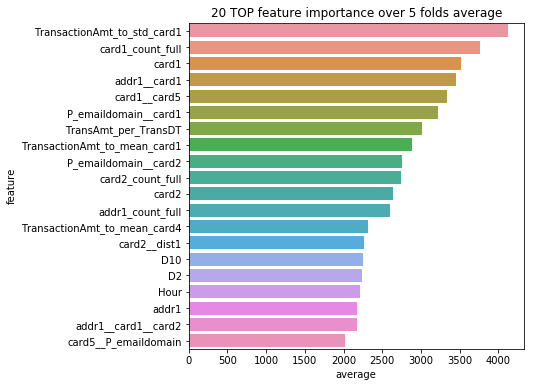

In [37]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

In [38]:
PREDICT = False
if PREDICT:
    # clf right now is the last model, trained with 80% of data and validated with 20%
    best_iter = clf.best_iteration
    print("best_iteration: ", best_iter)
    # clf = lgb.LGBMClassifier(**params, num_boost_round=int(best_iter * 1.1))
    # clf.fit(X, y)

    all_data = lgb.Dataset(X, label=y)
    all_clf  = lgb.train(params, all_data, num_boost_round = int(best_iter * 1.20), valid_sets = [all_data], verbose_eval=100) 

    # sub['isFraud'] = clf.predict_proba(test_X)[:, 1]
    sub['isFraud'] = all_clf.predict(test_X)
    sub.to_csv('ieee_cis_fraud_detection_v3.csv', index=False)

# 结果记录

- file/线下mean/线下fold5/线上
- ieee_cis_fraud_detection_v2.csv/0.92431/0.93523/0.9416


# 实验

- 不带交叉特征: 0.9021, 0.924753
- 原交叉特征:  0.90323, 0.927644
- 增加交叉特征: 0.902691, 0.924993
- 优化交叉特征: 0.90404, 0.927612
- 高阶交叉特征1 2个: 0.90372, 0.928267 最优
- 高阶交叉特征2 10个: 0.902636, 0.925677
- 高阶交叉特征2 5个: 0.903707, 0.926686

- 删除不重要的特征
- 保留全部:          0.90372,  0.928267
- feature_keep=400: 0.90240,  0.927373
- feature_keep=480: 0.90302,  0.926563
- feature_keep=180: 0.90218,  0.926139
- feature_keep=505: 0.904084, 0.926456
